In [2]:
options(warn=-1)
shhh <- suppressPackageStartupMessages # It's a library, so shhh!

shhh(library(tidyverse))
library(gapminder)
library(comprehenr)
library(ggplot2)
library(dplyr)
library(ggpubr)
shhh(library(KernSmooth))

theme_set(theme_bw())
options(warn=0)

In [3]:
geyser_df <- read.table('datos/Datos-geyser.txt', header=TRUE, sep=' ', )
head(geyser_df)

,D,Y,X
,<int>,<int>,<dbl>
1,1,78,4.4
2,1,74,3.9
3,1,68,4.0
4,1,76,4.0
5,1,80,3.5
6,1,84,4.1


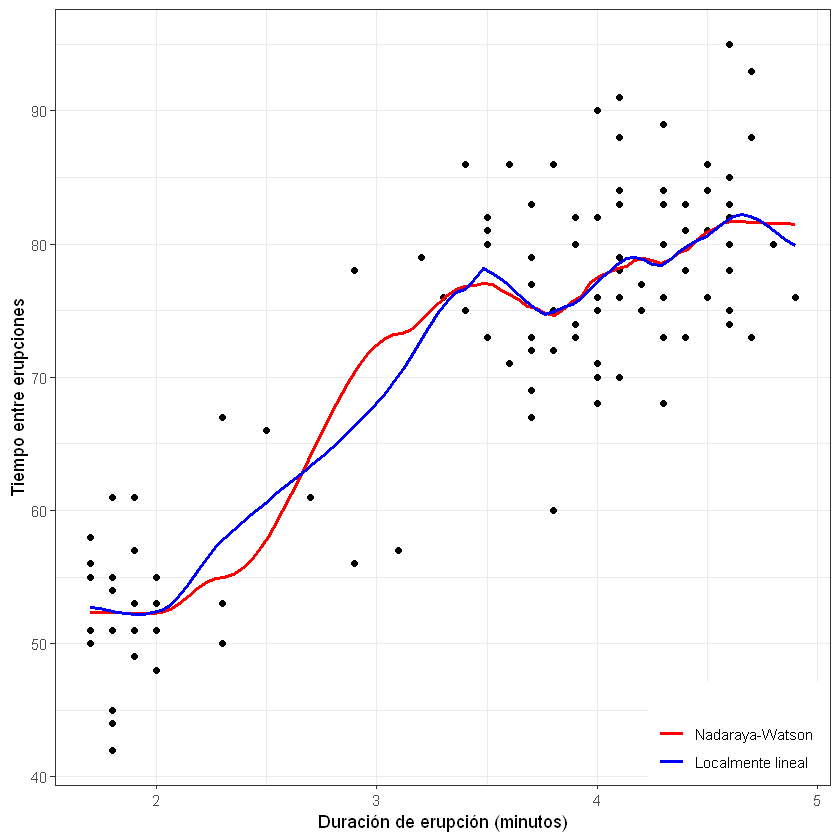

In [4]:
n <- length(geyser_df$X)
loc_lineal <- locpoly(geyser_df$X, geyser_df$Y, degree = 1, gridsize=n,
                      bandwidth = dpill(geyser_df$X, geyser_df$Y))

ggplot(geyser_df, aes(X, Y)) +
  geom_point() +
  geom_smooth(formula=y~x, method = 'loess', se = FALSE, span = 0.25, method.args = list(degree=0), aes(col='Nadaraya-Watson')) +
  geom_smooth(formula=y~x, method = 'loess', se = FALSE, span = 0.25, method.args = list(degree=1), aes(col='Localmente lineal')) +
  scale_colour_manual("", breaks = c('Nadaraya-Watson', 'Localmente lineal'), values = c('red', 'blue')) +
  labs(x = 'Duración de erupción (minutos)', y = 'Tiempo entre erupciones') +
  theme(legend.justification=c(1,0), legend.position=c(1,0))

### Ejercicio 4

**a)**

| Variables incluidas en el modelo |          Coeficientes de regresión          |    SCR   |
|:--------------------------------:|:-------------------------------------------:|:--------:|
|    Sólo término independiente    |                  $\beta_0$                  | 42644.00 |
|               $x_1$              |            $\beta_0$ y $\beta_1$            |  8352.28 |
|               $x_2$              |            $\beta_0$ y $\beta_2$            | 36253.69 |
|               $x_3$              |            $\beta_0$ y $\beta_3$            | 36606.19 |
|           $x_1$ y $x_2$          |       $\beta_0$, $\beta_1$ y $\beta_2$      |  7713.13 |
|           $x_1$ y $x_3$          |       $\beta_0$, $\beta_1$ y $\beta_3$      |  762.55  |
|           $x_2$ y $x_3$          |       $\beta_0$, $\beta_2$ y $\beta_3$      | 32700.17 |
|       $x_1$, $x_2$ y $x_3$       | $\beta_0$, $\beta_1$, $\beta_2$ y $\beta_3$ |  761.41  |

In [3]:
n <- 20
p <- 3
all_scrs <- c(42644, 8352.28, 36253.69, 36606.19, 7713.13, 762.55, 32700.17, 761.41)
scr <- all_scrs[8]
sce <- all_scrs[1] - scr

source <- c("Complete model", "Residuals")
df <- c(p, n - p - 1)
sum_sq <- c(sce, scr)
mean_sq <- sum_sq/df
f <- c(mean_sq[1]/mean_sq[2], NA)
pr_f <- c(pf(f[1], df1=p, df2=n-p-1, lower.tail=FALSE), NA)

variance_table <- data.frame(Source=source, Df=df, Sum_Sq=sum_sq, Mean_Sq=mean_sq, F_value=f, p_value=pr_f)
variance_table

Source,Df,Sum_Sq,Mean_Sq,F_value,p_value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Complete model,3,41882.59,13960.86333,293.3686,3.421043e-14
Residuals,16,761.41,47.58812,NA,NA


**b) Caso $H_0: \beta_2=0$.**

In [11]:
reduced_model_p_value <- function(total_scr, reduced_scr, n, p, k) {
    numerator <- (reduced_scr - total_scr) / k
    denominator <- total_scr / (n - p - 1)
    pf(numerator/denominator, df1=k, df2=n-p-1, lower.tail=FALSE)
}

k <- 1
print(paste('p-value: ', reduced_model_p_value(all_scrs[8], all_scrs[3], n, p, k)))

[1] "p-value:  7.50451101383861e-15"


Puesto que obtenemos un *p-value* de $\approx 7.5 \cdot 10^{-15} < 0.05$, rechazamos la hipótesis nula. Es decir, **la variable $x_2$ si es significativa para la predicción de $y$**.

**b) Caso $H_0: \beta_1 = \beta_3 = 0$.**

In [12]:
k <- 2
print(paste('p-value: ', reduced_model_p_value(all_scrs[8], all_scrs[6], n, p, k)))

[1] "p-value:  0.988102521110228"


Puesto que obtenemos un *p-value* de $\approx 0.99 > 0.05$, no hay suficiente evidencia para rechazar la hipótesis nula. Es decir, **las variable $x_1$ y $x_3$ no son significativas para la predicción de $y$**.

### Ejercicio 6

Sean $Y_1$, $Y_2$ e $Y_3$ tres variables aleatorias independientes con distribución normal y varianza $\sigma^2$. Supongamos que $\mu$ es la media de $Y_1$, $\lambda$ es la media de $Y_2$ y $\lambda + \mu$ es la media de $Y_3$, donde $\lambda, mu \in \mathbb R$.

**a)** Demuestra que el vector $Y = (Y_1, Y_2, Y_3)'$0 verifica el modelo de regresión múltiple $Y = X\beta + \epsilon$. Para ello, determina la matriz de diseño $X$, el vector de parámetros $\beta$ y la distribución de las variables de error $\epsilon$.

Podemos expresar el vector de variables independientes de la siguiente forma:

$$\begin{pmatrix}
    Y_1 \\
    Y_2 \\
    Y_3 \\
\end{pmatrix} =
\underbrace{ \begin{pmatrix}
    1 & 0 \\
    0 & 1 \\
    1 & 1
\end{pmatrix} }_{X}
\underbrace{ \begin{pmatrix}
    \mu \\
    \lambda
\end{pmatrix} }_{\beta} +
\begin{pmatrix}
    \epsilon_1 \\
    \epsilon_2 \\
    \epsilon_3
\end{pmatrix} \quad
\epsilon_i \sim N(0, \sigma^2)
$$

Obteniendo el siguiente modelo de regresión múltiple:

$$
   Y \sim N(X\beta, \sigma^2 I)
$$

**b)** Calcula los estimadores de máxima verosimilitud (equivalentemente, de mínimos cuadrados) de $\lambda$ y $\mu$.

Sabemos que el estimador de mínimos cuadrados puede calcular utilizando la siguiente expresión:

$$
    \hat \beta = (X'X)^{-1}X'Y
$$

Sin embargo, para demostrar esta expresión en clase nos basamos en que la matriz de diseño tenía una columna de unos (el modelo tenía un término independiente $\beta_0$). ¿Es ésta expresión cierta si el modelo carece de término independiente?

La respuesta es afirmativa. Para obtenerla sin hacer uso de dicha hipótesis podemos simplemente obtener el valor que minimiza el error cuadrado mínimo derivando e igualando a $0$ en la siguiente expresión:

$$
    L(\sigma, \beta) = \; \parallel Y - X\beta \;\parallel^2_2
$$

Las cuentas no son complicadas, puede consultarse la demostración completa en [Wikipedia](https://en.wikipedia.org/wiki/Least_squares#Linear_least_squares). Calculemos estos valores para nuestro caso particular:

$$
X'X =
\begin{pmatrix}
    1 & 0 & 1 \\
    0 & 1 & 1 \\
\end{pmatrix}
\begin{pmatrix}
    1 & 0 \\
    0 & 1 \\
    1 & 1
\end{pmatrix} = 
\begin{pmatrix}
    2 & 1 \\
    1 & 2
\end{pmatrix}
$$

$$
(X'X)^{-1} = \frac{1}{3}
\begin{pmatrix}
    2 & -1 \\
    -1 & 2
\end{pmatrix}
$$

$$
(X'X)^{-1}X' = \frac{1}{3}
\begin{pmatrix}
    2 & -1 \\
    -1 & 2
\end{pmatrix}
\begin{pmatrix}
    1 & 0 & 1 \\
    0 & 1 & 1 \\
\end{pmatrix} = \frac{1}{3}
\begin{pmatrix}
    2 & -1 & 1 \\
    -1 & 2 & 1 \\
\end{pmatrix}
$$

$$
\hat \beta = (X'X)^{-1}X'Y =
\begin{pmatrix}
    2 & -1 & 1 \\
    -1 & 2 & 1 \\
\end{pmatrix}
\begin{pmatrix}
    Y_1 \\
    Y_2 \\
    Y_3 \\
\end{pmatrix} = \frac{1}{3}
\begin{pmatrix}
    2 Y_1 - Y_2 + Y_3 \\
    -Y_1 + 2 Y_2 + Y_3
\end{pmatrix}
$$


**c)** Calcula la distribución del vector $(\hat \lambda, \hat \mu)'$, formado por los estimadores calculados en el apartado anterior.

Puesto que el vector de variables independientes cumple

$$
   Y \sim N(X\beta, \sigma^2 I)
$$

Y sabiendo que $\hat \beta = (X'X)^{-1}X'Y$, obtenemos que $\hat \beta$ sigue una distribución normal multivariante:

$$
   \hat \beta \sim N( ((X'X)^{-1}X') \cdot X\beta, ((X'X)^{-1}X') \cdot \sigma^2 I \cdot ((X'X)^{-1}X')')
$$

Para la esperanza:

$$
    \mathbb E [\hat\beta] = (X'X)^{-1}X' \cdot X\beta = (X'X)^{-1} \cdot (X'X) \beta = \beta
$$

Luego el estimador es insesgado. Por otro lado, para la varianza hemos de ver que $X'X$ es simétrica (y por lo tanto su inversa también lo será):

$$
    (X'X)' = X'X'' = X'X
$$

Por lo tanto, la varianza cumple:

$$
\begin{align}
    \text{Var}[\hat\beta] & = ((X'X)^{-1}X') \cdot \sigma^2 I \cdot ((X'X)^{-1}X')' \\
     & = \sigma^2 (X'X)^{-1} (X'X) (X'X)^{-1} \\
     & = \sigma^2 (X'X)^{-1} \\
\end{align}
$$

Obtenemos así la expresión reducida de la distribución que siguen los estimadores:

$$
   \hat \beta \sim N( \beta, \sigma^2(X'X)^{-1})
$$

### Ejercicio 10

Los datos *fuel2001* del fichero *combustible.RData* corresponden al consumo de combustible (y otras variables relacionadas) en los estados de EE.UU.
Se desea explicar la variable ***FuelC*** en función del resto de la información.

In [6]:
datos <- 'http://verso.mat.uam.es/~joser.berrendero/datos/combustible.RData'
load(url(datos))
head(fuel2001)

,Drivers,FuelC,Income,Miles,MPC,Pop,Tax
,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>
AL,3559897,2382507,23471,94440,12737.00,3451586,18.0
AK,472211,235400,30064,13628,7639.16,457728,8.0
AZ,3550367,2428430,25578,55245,9411.55,3907526,18.0
AR,1961883,1358174,22257,98132,11268.40,2072622,21.7
CA,21623793,14691753,32275,168771,8923.89,25599275,18.0
CO,3287922,2048664,32949,85854,9722.73,3322455,22.0


**a)** Representa en un plano las dos primeras componentes principales de estos datos estandarizados (consulta la ayuda de *prcomp*). ¿Son suficientes estas dos componentes para explicar un alto porcentaje de la varianza?

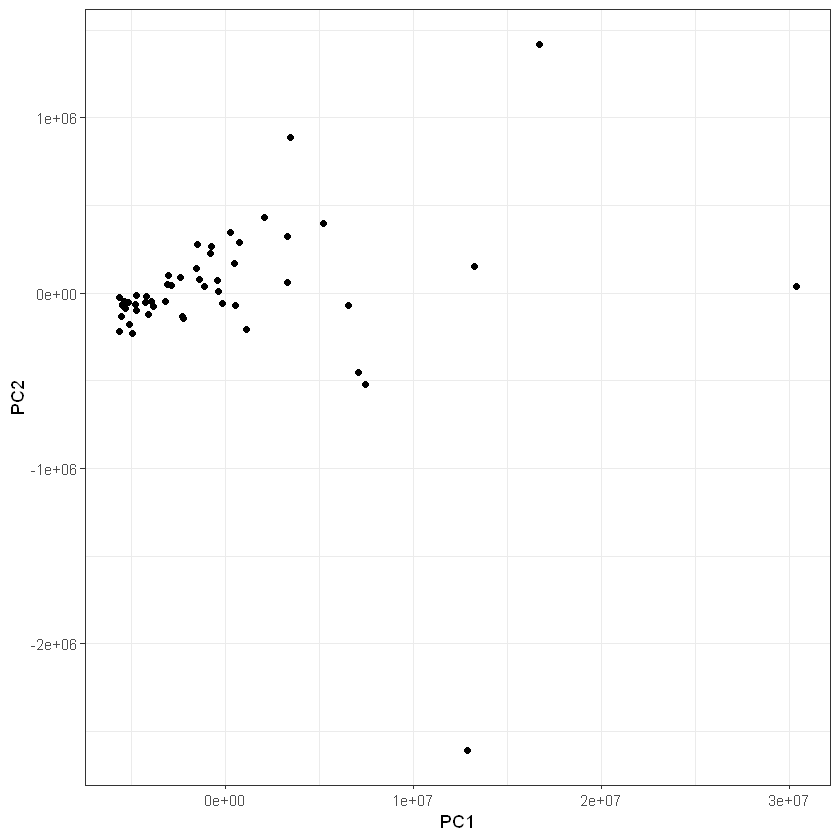

In [19]:
pca_analysis <- prcomp(fuel2001)
pcas <- as.data.frame(pca_analysis$x)
ggplot(pcas, aes(PC1, PC2)) +
    geom_point() +
    labs(x='PC1', y='PC2')

Importance of components:
                             PC1       PC2       PC3       PC4  PC5  PC6  PC7
Standard deviation     6.715e+06 4.764e+05 2.734e+05 3.356e+04 3933 1545 4.14
Proportion of Variance 9.933e-01 5.000e-03 1.650e-03 2.000e-05    0    0 0.00
Cumulative Proportion  9.933e-01 9.983e-01 1.000e+00 1.000e+00    1    1 1.00

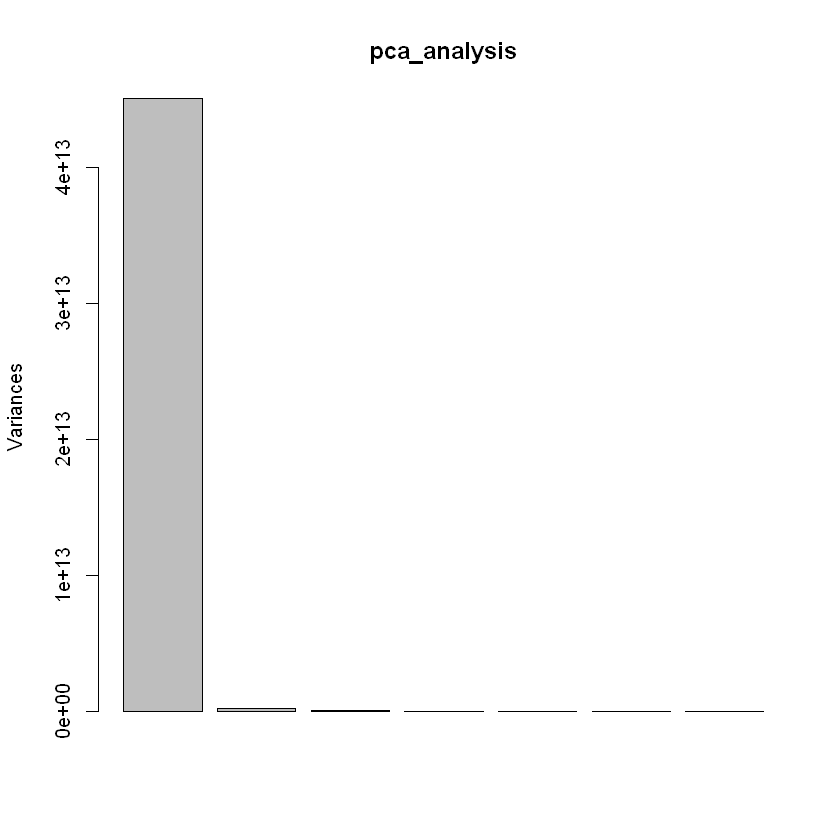

In [22]:
summary(pca_analysis)
plot(pca_analysis)z

**b)** Ajusta el modelo completo con todas las variables. En este modelo completo, contrasta la hipótesis nula de que los coeficientes de las variables **Income**, **MPC** y **Tax** son simultáneamente iguales a cero.

**c)** De acuerdo con el método iterativo hacia adelante y el criterio BIC, ¿cúal es el modelo óptimo?

**d)** Ajusta el modelo usando lasso, con el parámetro de regularizaci´on seleccionado mediante validación cruzada.

**e)** Ajusta el modelo usando **ridge**, con el parámetro de regularización seleccionado mediante validación cruzada.